In [2]:
import pandas as pd
import numpy as np 
from datetime import datetime, timedelta
import holidays
from analysis import * 
import matplotlib.pyplot as plt 

In [3]:
poland_holidays = holidays.CountryHoliday('Poland')

In [4]:
data = pd.read_csv("Data/daneOkresoweKSE.csv", sep=';', skiprows=1, names=['Date', 'Hour', 'Minute', 'Load'])
Electric = data.copy()
Electric['Date'] = pd.to_datetime(Electric.Date)
Electric.loc[Electric.Hour == 24, 'Date'] = Electric.loc[Electric.Hour == 24, 'Date'] + timedelta(days=1)
Electric.loc[Electric.Hour == 24, 'Hour'] = 0
Electric.Date = pd.to_datetime(Electric.Date.astype(str) + ' ' + Electric['Hour'].astype(str) + ':' + Electric.Minute.astype(str) + ':00')
Electric.set_index('Date', inplace=True)

resample_cost = 'h'
Electric_day = Electric.resample(resample_cost).agg({'Hour': np.mean, 'Minute': np.mean, 'Load': np.sum})
Electric_day.reset_index(inplace=True)
Electric_day.loc[Electric_day.Load < 20000, 'Load'] = np.nan
Electric_day.Load.interpolate(inplace=True)

Electric_day['Seconds'] = (Electric_day.Date - Electric_day.Date[0]).dt.total_seconds()
Electric_day = Electric_day[['Date', 'Seconds', 'Load']]
Electric_day['Day'] = Electric_day['Date'].dt.day_of_week
Electric_day['Minutes'] = Electric_day['Date'].dt.minute
Electric_day['Hour'] = Electric_day['Date'].dt.hour
Electric_day['Holiday'] = Electric_day.Date.apply(lambda x: x in poland_holidays)
Electric_day['Day id'] = Electric_day.Date.dt.day_of_year

In [5]:
cutting_day = '2016-12-22'
train_set = Electric_day[Electric_day.Date <= pd.to_datetime(cutting_day, format='%Y-%m-%d')]
test_set = Electric_day[Electric_day.Date >= pd.to_datetime(cutting_day, format='%Y-%m-%d')]

In [6]:
n_days_ahead = test_set.Date.dt.day_of_year.unique().shape[0]

In [7]:
working_days = train_set[~train_set.Holiday].reset_index(drop=True)
festivities = train_set[train_set.Holiday].reset_index(drop=True)

In [8]:
f = {'Load': ['mean', q1, q2]}
pred_working_days = working_days.groupby(['Day', 'Hour']).agg(f)
pred_festivities = festivities.groupby(['Day id', 'Hour']).agg(f)

In [9]:
forecasting = []

for day in pd.date_range(cutting_day, periods=n_days_ahead, freq="d"):
    if any(day.day_of_year == festivities['Day id']):
        forecasting.append(pred_festivities.loc[day.day_of_year]['Load'].values)
    else:
        forecasting.append(pred_working_days.loc[day.day_of_week]['Load'].values)

forecasting = np.concatenate(forecasting) 

In [10]:
forecasting

array([[65004.359375  , 57416.145     , 73055.7425    ],
       [62806.77785235, 54849.725     , 70808.42      ],
       [61806.27673378, 53873.975     , 69981.395     ],
       [61918.83221477, 53896.085     , 70024.05      ],
       [62097.58299776, 53150.64      , 70889.035     ],
       [63129.69060403, 52696.705     , 72817.7       ],
       [69058.3261745 , 58085.665     , 79953.83      ],
       [76896.51498881, 65397.54      , 88234.36      ],
       [81103.44451902, 70242.305     , 91630.79      ],
       [83040.75659955, 72407.795     , 93403.39      ],
       [83002.89038031, 72773.86      , 93019.83      ],
       [84093.51364653, 73837.84      , 94220.62      ],
       [84235.98791946, 74348.79      , 93984.125     ],
       [84678.67561521, 74444.145     , 94793.29      ],
       [83062.29328859, 73090.645     , 93387.74      ],
       [82288.32684564, 72048.36      , 93812.745     ],
       [82455.67136465, 70835.555     , 97701.07      ],
       [82926.84228188, 69891.8

In [11]:
days_forecasted = pd.date_range(cutting_day, periods=n_days_ahead*24, freq="h")

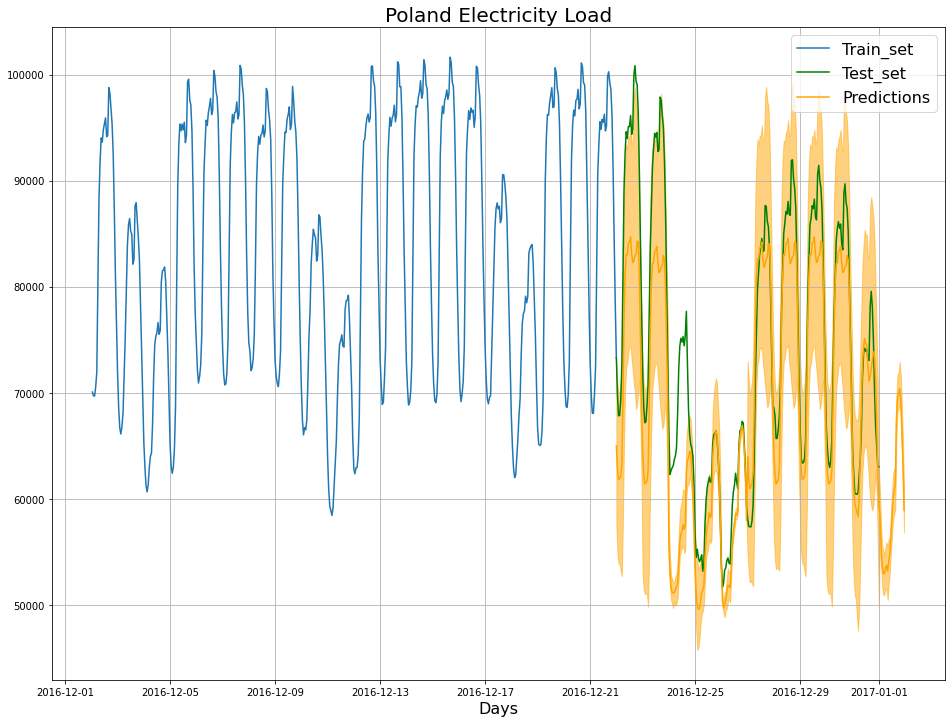

In [12]:
plt.figure(figsize=(16,12))
plt.plot(train_set.iloc[-20*24:, 0], train_set.iloc[-20*24:, 2], label='Train_set')
plt.plot(test_set['Date'], test_set['Load'], color='green', label='Test_set')
plt.plot(days_forecasted, forecasting[:, 0], color='orange', label='Predictions')
plt.fill_between(x=days_forecasted, y1=forecasting[:, 1], y2=forecasting[:, 2], color='orange', alpha=0.5)
plt.legend(fontsize=16)
plt.title('Poland Electricity Load', fontsize=20)
plt.xlabel('Days', fontsize=16)
plt.grid()
#plt.savefig('./Results/PSF_forecasting.png', transparent=True)